In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ZhangCTReconstruction(nn.Module):
    def __init__(self):
        super(ZhangCTReconstruction, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # (B,64,64,180)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # (B,64,64,180)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # (B,32,64,180)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 1, kernel_size=1),  # Final 1-channel output
        )

    def forward(self, x):
        x = self.encoder(x)
        x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)
        return x


In [ ]:
model = ZhangCTReconstruction().to("cuda" if torch.cuda.is_available() else "cpu")
dummy_input = torch.randn((1, 1, 90, 128)).to("cuda" if torch.cuda.is_available() else "cpu")
output = model(dummy_input)

print("✅ Input shape :", dummy_input.shape)
print("✅ Output shape:", output.shape)


✅ Input shape : torch.Size([1, 1, 90, 128])
✅ Output shape: torch.Size([1, 1, 64, 64])


In [ ]:
from google.colab import files
import zipfile
import os

# Create directory
os.makedirs("data/sinograms", exist_ok=True)

# Upload sinogram zip
print("📁 Please upload the sinogram ZIP file (e.g., sinograms.zip)")
uploaded_sino = files.upload()

# Extract
for fname in uploaded_sino:
    with zipfile.ZipFile(fname, 'r') as zip_ref:
        zip_ref.extractall("data/sinograms")

print("✅ Sinograms unzipped to: data/sinograms")


📁 Please upload the sinogram ZIP file (e.g., sinograms.zip)


Saving sino_finallll.zip to sino_finallll.zip
✅ Sinograms unzipped to: data/sinograms


In [ ]:
# Create directory
os.makedirs("data/ct_images", exist_ok=True)

# Upload CT image zip
print("📁 Please upload the CT image ZIP file (e.g., ct_images.zip)")
uploaded_ct = files.upload()

# Extract
for fname in uploaded_ct:
    with zipfile.ZipFile(fname, 'r') as zip_ref:
        zip_ref.extractall("data/ct_images")

print("✅ CT images unzipped to: data/ct_images")


📁 Please upload the CT image ZIP file (e.g., ct_images.zip)


Saving CT_64x64_RESIZED.zip to CT_64x64_RESIZED.zip
✅ CT images unzipped to: data/ct_images


✅ Matched sinogram-CT pairs: 125
📦 Training samples: 100
📦 Testing samples: 25


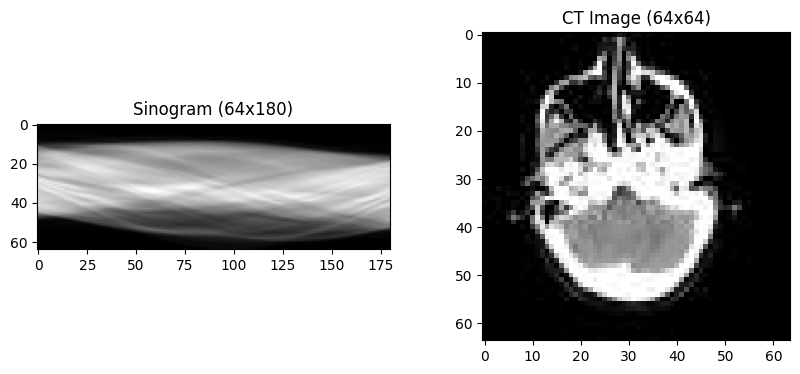

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

# Step 1: Extract base names and match pairs
def get_basenames(folder, suffix_to_strip, extension):
    return sorted([
        f.replace(suffix_to_strip + extension, "")
        for f in os.listdir(folder)
        if f.endswith(extension) and not f.startswith("._")
    ])

sinogram_path = "data/sinograms"
ct_path = "data/ct_images"

sino_basenames = get_basenames(sinogram_path, "_sinogram", ".png")
ct_basenames = get_basenames(ct_path, "", ".jpg")

matched_basenames = sorted(list(set(sino_basenames) & set(ct_basenames)))
print(f"✅ Matched sinogram-CT pairs: {len(matched_basenames)}")

# Step 2: Dataset
class CTDataset(torch.utils.data.Dataset):
    def __init__(self, sinogram_dir, ct_dir, basenames):
        self.sinogram_dir = sinogram_dir
        self.ct_dir = ct_dir
        self.basenames = basenames
        self.sino_transform = transforms.Compose([
            transforms.Resize((64, 180)),
            transforms.ToTensor()
        ])
        self.ct_transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.basenames)

    def __getitem__(self, idx):
        base = self.basenames[idx]
        sino_path = os.path.join(self.sinogram_dir, base + "_sinogram.png")
        ct_path = os.path.join(self.ct_dir, base + ".jpg")
        sino = Image.open(sino_path).convert("L")
        ct = Image.open(ct_path).convert("L")
        return self.sino_transform(sino), self.ct_transform(ct)

# Step 3: Dataset + DataLoader
dataset = CTDataset(sinogram_path, ct_path, matched_basenames)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False)

print(f"📦 Training samples: {len(train_ds)}")
print(f"📦 Testing samples: {len(test_ds)}")

# Step 4: Visual sanity check
import matplotlib.pyplot as plt

for sinos, cts in train_loader:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(sinos[0][0], cmap='gray')
    plt.title("Sinogram (64x180)")
    plt.subplot(1, 2, 2)
    plt.imshow(cts[0][0], cmap='gray')
    plt.title("CT Image (64x64)")
    plt.show()
    break


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# Initialize model
model = ZhangCTReconstruction().to(device)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

print("✅ Model, optimizer, and scheduler initialized.")


✅ Using device: cuda
✅ Model, optimizer, and scheduler initialized.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return 100
    return 10 * torch.log10(1.0 / mse)

def calculate_ssim(pred, target):
    """
    Compute SSIM between two single-channel images (64x64).
    Inputs: pred, target - shape (B, 1, 64, 64)
    Returns: SSIM score (float)
    """
    pred_np = pred[0, 0].detach().cpu().numpy()
    target_np = target[0, 0].detach().cpu().numpy()
    return ssim(pred_np, target_np, data_range=1.0, win_size=7, channel_axis=None)



num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for sinos, cts in loop:
        sinos, cts = sinos.to(device), cts.to(device)

        outputs = model(sinos)
        mse_loss = criterion(outputs, cts)
        ssim_value = calculate_ssim(outputs, cts)
        ssim_loss = 1 - ssim_value  # since higher SSIM is better

        loss = 0.5 * mse_loss + 0.5 * ssim_loss


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        psnr = calculate_psnr(outputs, cts)

        running_loss += loss.item()
        running_psnr += psnr.item()
        loop.set_postfix(loss=loss.item(), psnr=psnr.item())

    avg_loss = running_loss / len(train_loader)
    avg_psnr = running_psnr / len(train_loader)
    print(f"📘 Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}, Avg PSNR: {avg_psnr:.2f} dB, SSIM: {ssim_value:.3f}")


    scheduler.step(avg_loss)
    print(f"📘 Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}, Avg PSNR: {avg_psnr:.2f} dB")


Epoch 1/30: 100%|██████████| 25/25 [00:00<00:00, 58.60it/s, loss=0.546, psnr=9.63]


📘 Epoch 1 | Avg Loss: 0.5799, Avg PSNR: 8.02 dB, SSIM: 0.017
📘 Epoch 1 | Avg Loss: 0.5799, Avg PSNR: 8.02 dB


Epoch 2/30: 100%|██████████| 25/25 [00:00<00:00, 63.98it/s, loss=0.515, psnr=10.5]


📘 Epoch 2 | Avg Loss: 0.5234, Avg PSNR: 10.19 dB, SSIM: 0.058
📘 Epoch 2 | Avg Loss: 0.5234, Avg PSNR: 10.19 dB


Epoch 3/30: 100%|██████████| 25/25 [00:00<00:00, 68.05it/s, loss=0.526, psnr=10.8]


📘 Epoch 3 | Avg Loss: 0.5110, Avg PSNR: 10.84 dB, SSIM: 0.030
📘 Epoch 3 | Avg Loss: 0.5110, Avg PSNR: 10.84 dB


Epoch 4/30: 100%|██████████| 25/25 [00:00<00:00, 66.41it/s, loss=0.525, psnr=11.2]


📘 Epoch 4 | Avg Loss: 0.5070, Avg PSNR: 10.98 dB, SSIM: 0.026
📘 Epoch 4 | Avg Loss: 0.5070, Avg PSNR: 10.98 dB


Epoch 5/30: 100%|██████████| 25/25 [00:00<00:00, 66.07it/s, loss=0.529, psnr=10.2]


📘 Epoch 5 | Avg Loss: 0.5089, Avg PSNR: 11.06 dB, SSIM: 0.036
📘 Epoch 5 | Avg Loss: 0.5089, Avg PSNR: 11.06 dB


Epoch 6/30: 100%|██████████| 25/25 [00:00<00:00, 63.87it/s, loss=0.511, psnr=10.8]


📘 Epoch 6 | Avg Loss: 0.5024, Avg PSNR: 11.12 dB, SSIM: 0.062
📘 Epoch 6 | Avg Loss: 0.5024, Avg PSNR: 11.12 dB


Epoch 7/30: 100%|██████████| 25/25 [00:00<00:00, 58.68it/s, loss=0.521, psnr=10.8]


📘 Epoch 7 | Avg Loss: 0.5072, Avg PSNR: 11.13 dB, SSIM: 0.043
📘 Epoch 7 | Avg Loss: 0.5072, Avg PSNR: 11.13 dB


Epoch 8/30: 100%|██████████| 25/25 [00:00<00:00, 70.95it/s, loss=0.501, psnr=11.1]


📘 Epoch 8 | Avg Loss: 0.5007, Avg PSNR: 11.17 dB, SSIM: 0.076
📘 Epoch 8 | Avg Loss: 0.5007, Avg PSNR: 11.17 dB


Epoch 9/30: 100%|██████████| 25/25 [00:00<00:00, 73.93it/s, loss=0.486, psnr=11.6]


📘 Epoch 9 | Avg Loss: 0.5015, Avg PSNR: 11.22 dB, SSIM: 0.098
📘 Epoch 9 | Avg Loss: 0.5015, Avg PSNR: 11.22 dB


Epoch 10/30: 100%|██████████| 25/25 [00:00<00:00, 64.91it/s, loss=0.497, psnr=11.8]


📘 Epoch 10 | Avg Loss: 0.4999, Avg PSNR: 11.24 dB, SSIM: 0.073
📘 Epoch 10 | Avg Loss: 0.4999, Avg PSNR: 11.24 dB


Epoch 11/30: 100%|██████████| 25/25 [00:00<00:00, 72.23it/s, loss=0.488, psnr=10.9]


📘 Epoch 11 | Avg Loss: 0.4983, Avg PSNR: 11.23 dB, SSIM: 0.105
📘 Epoch 11 | Avg Loss: 0.4983, Avg PSNR: 11.23 dB


Epoch 12/30: 100%|██████████| 25/25 [00:00<00:00, 73.30it/s, loss=0.506, psnr=11.1]


📘 Epoch 12 | Avg Loss: 0.5043, Avg PSNR: 11.25 dB, SSIM: 0.065
📘 Epoch 12 | Avg Loss: 0.5043, Avg PSNR: 11.25 dB


Epoch 13/30: 100%|██████████| 25/25 [00:00<00:00, 65.20it/s, loss=0.489, psnr=11.3]


📘 Epoch 13 | Avg Loss: 0.4941, Avg PSNR: 11.29 dB, SSIM: 0.097
📘 Epoch 13 | Avg Loss: 0.4941, Avg PSNR: 11.29 dB


Epoch 14/30: 100%|██████████| 25/25 [00:00<00:00, 72.86it/s, loss=0.496, psnr=10.6]


📘 Epoch 14 | Avg Loss: 0.4861, Avg PSNR: 11.26 dB, SSIM: 0.095
📘 Epoch 14 | Avg Loss: 0.4861, Avg PSNR: 11.26 dB


Epoch 15/30: 100%|██████████| 25/25 [00:00<00:00, 69.78it/s, loss=0.496, psnr=11.5]


📘 Epoch 15 | Avg Loss: 0.4998, Avg PSNR: 11.27 dB, SSIM: 0.078
📘 Epoch 15 | Avg Loss: 0.4998, Avg PSNR: 11.27 dB


Epoch 16/30: 100%|██████████| 25/25 [00:00<00:00, 66.87it/s, loss=0.471, psnr=11.7]


📘 Epoch 16 | Avg Loss: 0.4974, Avg PSNR: 11.28 dB, SSIM: 0.125
📘 Epoch 16 | Avg Loss: 0.4974, Avg PSNR: 11.28 dB


Epoch 17/30: 100%|██████████| 25/25 [00:00<00:00, 73.53it/s, loss=0.508, psnr=10.7]


📘 Epoch 17 | Avg Loss: 0.5048, Avg PSNR: 11.32 dB, SSIM: 0.069
📘 Epoch 17 | Avg Loss: 0.5048, Avg PSNR: 11.32 dB


Epoch 18/30: 100%|██████████| 25/25 [00:00<00:00, 64.18it/s, loss=0.509, psnr=11.9]


📘 Epoch 18 | Avg Loss: 0.4972, Avg PSNR: 11.33 dB, SSIM: 0.045
📘 Epoch 18 | Avg Loss: 0.4972, Avg PSNR: 11.33 dB


Epoch 19/30: 100%|██████████| 25/25 [00:00<00:00, 64.84it/s, loss=0.452, psnr=11.2]


📘 Epoch 19 | Avg Loss: 0.4975, Avg PSNR: 11.33 dB, SSIM: 0.171
📘 Epoch 19 | Avg Loss: 0.4975, Avg PSNR: 11.33 dB


Epoch 20/30: 100%|██████████| 25/25 [00:00<00:00, 71.29it/s, loss=0.489, psnr=12.2]


📘 Epoch 20 | Avg Loss: 0.5007, Avg PSNR: 11.32 dB, SSIM: 0.083
📘 Epoch 20 | Avg Loss: 0.5007, Avg PSNR: 11.32 dB


Epoch 21/30: 100%|██████████| 25/25 [00:00<00:00, 73.38it/s, loss=0.504, psnr=11.4]


📘 Epoch 21 | Avg Loss: 0.5010, Avg PSNR: 11.36 dB, SSIM: 0.066
📘 Epoch 21 | Avg Loss: 0.5010, Avg PSNR: 11.36 dB


Epoch 22/30: 100%|██████████| 25/25 [00:00<00:00, 71.52it/s, loss=0.47, psnr=12.1]


📘 Epoch 22 | Avg Loss: 0.4952, Avg PSNR: 11.36 dB, SSIM: 0.123
📘 Epoch 22 | Avg Loss: 0.4952, Avg PSNR: 11.36 dB


Epoch 23/30: 100%|██████████| 25/25 [00:00<00:00, 72.99it/s, loss=0.505, psnr=11.1]


📘 Epoch 23 | Avg Loss: 0.5045, Avg PSNR: 11.38 dB, SSIM: 0.066
📘 Epoch 23 | Avg Loss: 0.5045, Avg PSNR: 11.38 dB


Epoch 24/30: 100%|██████████| 25/25 [00:00<00:00, 65.55it/s, loss=0.524, psnr=10.5]


📘 Epoch 24 | Avg Loss: 0.4965, Avg PSNR: 11.36 dB, SSIM: 0.042
📘 Epoch 24 | Avg Loss: 0.4965, Avg PSNR: 11.36 dB


Epoch 25/30: 100%|██████████| 25/25 [00:00<00:00, 71.60it/s, loss=0.492, psnr=11.4]


📘 Epoch 25 | Avg Loss: 0.5020, Avg PSNR: 11.38 dB, SSIM: 0.090
📘 Epoch 25 | Avg Loss: 0.5020, Avg PSNR: 11.38 dB


Epoch 26/30: 100%|██████████| 25/25 [00:00<00:00, 72.36it/s, loss=0.524, psnr=11]


📘 Epoch 26 | Avg Loss: 0.4994, Avg PSNR: 11.39 dB, SSIM: 0.032
📘 Epoch 26 | Avg Loss: 0.4994, Avg PSNR: 11.39 dB


Epoch 27/30: 100%|██████████| 25/25 [00:00<00:00, 65.58it/s, loss=0.507, psnr=11.5]


📘 Epoch 27 | Avg Loss: 0.4946, Avg PSNR: 11.41 dB, SSIM: 0.057
📘 Epoch 27 | Avg Loss: 0.4946, Avg PSNR: 11.41 dB


Epoch 28/30: 100%|██████████| 25/25 [00:00<00:00, 72.75it/s, loss=0.494, psnr=11]


📘 Epoch 28 | Avg Loss: 0.4981, Avg PSNR: 11.40 dB, SSIM: 0.091
📘 Epoch 28 | Avg Loss: 0.4981, Avg PSNR: 11.40 dB


Epoch 29/30: 100%|██████████| 25/25 [00:00<00:00, 66.69it/s, loss=0.528, psnr=10.7]


📘 Epoch 29 | Avg Loss: 0.4979, Avg PSNR: 11.40 dB, SSIM: 0.030
📘 Epoch 29 | Avg Loss: 0.4979, Avg PSNR: 11.40 dB


Epoch 30/30: 100%|██████████| 25/25 [00:00<00:00, 70.72it/s, loss=0.481, psnr=11.6]

📘 Epoch 30 | Avg Loss: 0.5010, Avg PSNR: 11.40 dB, SSIM: 0.107
📘 Epoch 30 | Avg Loss: 0.5010, Avg PSNR: 11.40 dB


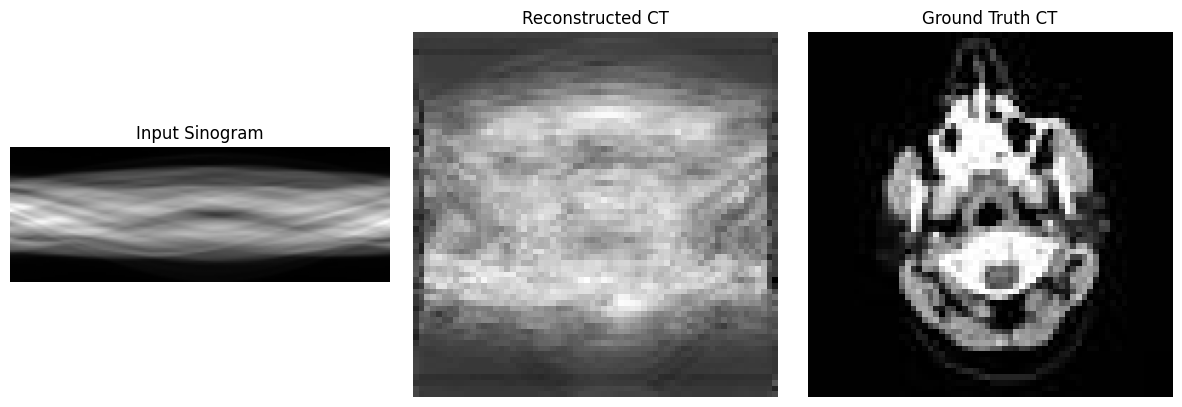

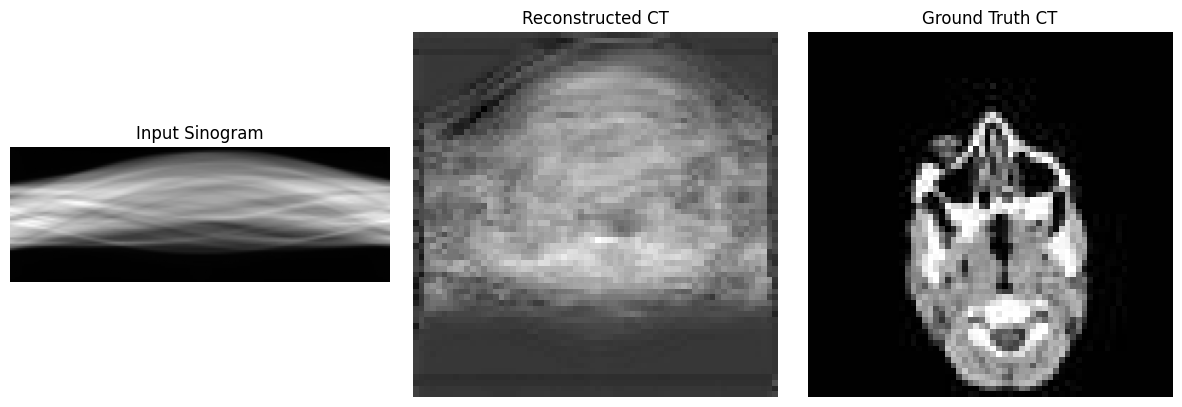

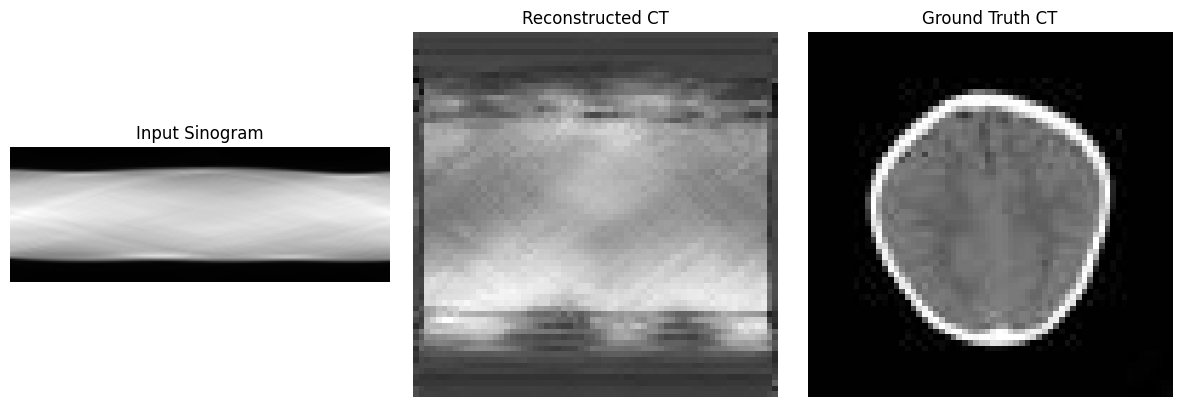

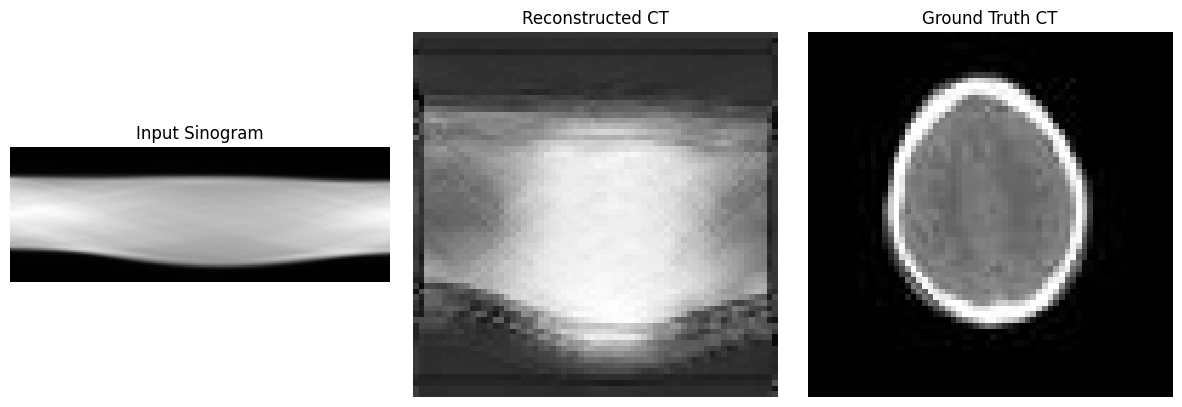

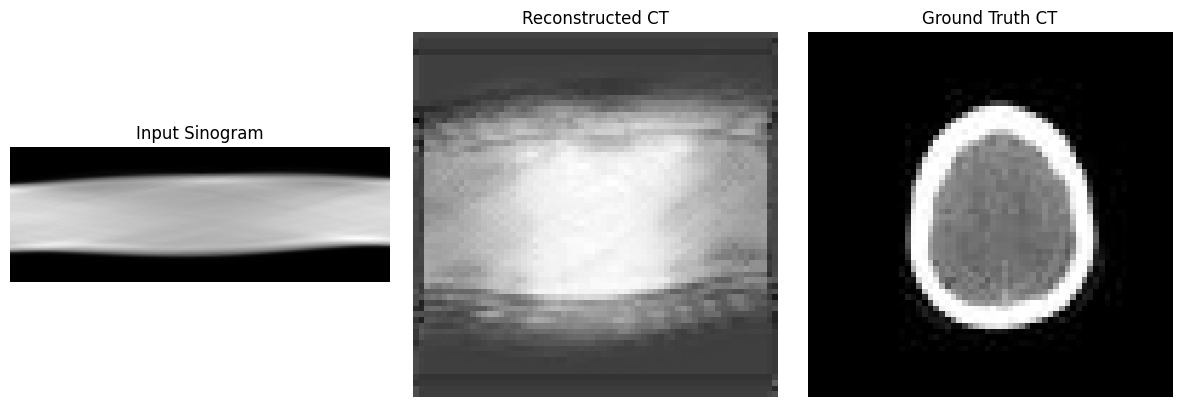

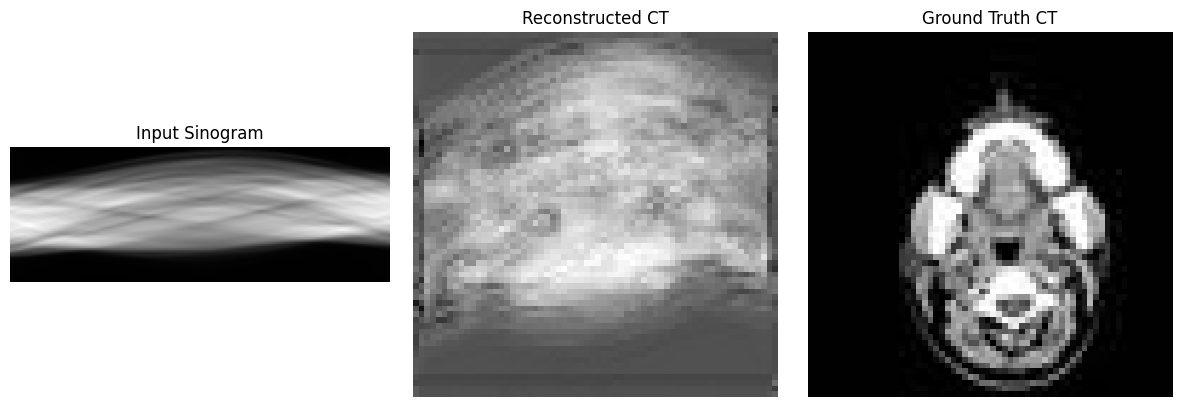

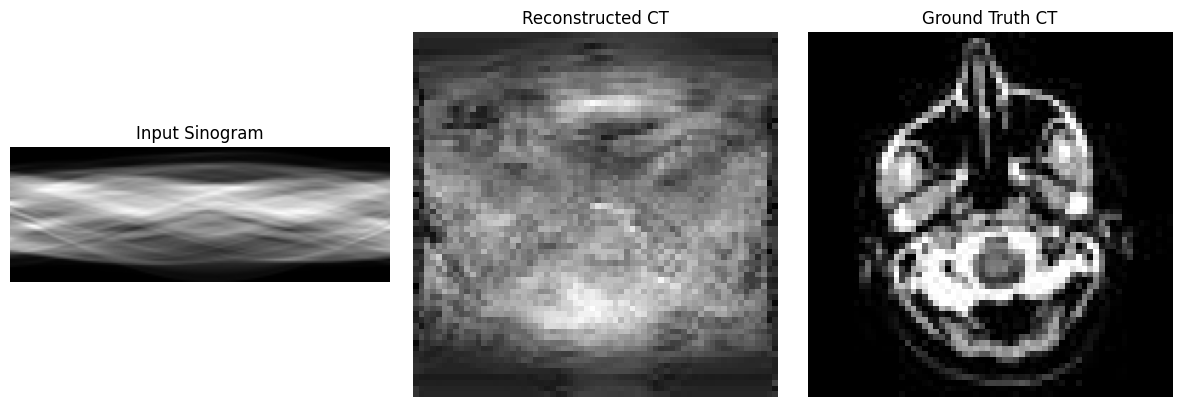

📊 Average PSNR on test set: 11.78 dB
📊 Average SSIM on test set: 0.061


In [ ]:
from skimage.metrics import structural_similarity as compare_ssim
import matplotlib.pyplot as plt

model.eval()
psnr_list = []
ssim_list = []

with torch.no_grad():
    for sinos, cts in test_loader:
        sinos, cts = sinos.to(device), cts.to(device)
        outputs = model(sinos)

        for i in range(outputs.size(0)):
            pred = outputs[i].cpu().squeeze().numpy()
            target = cts[i].cpu().squeeze().numpy()
            input_sino = sinos[i].cpu().squeeze().numpy()

            # PSNR
            mse = np.mean((pred - target) ** 2)
            psnr = 10 * np.log10(1.0 / mse)
            psnr_list.append(psnr)

            # SSIM
            ssim = compare_ssim(pred, target, data_range=1.0)
            ssim_list.append(ssim)

            # Show a few sample outputs
            if i == 0:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(input_sino, cmap='gray')
                plt.title("Input Sinogram")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(pred, cmap='gray')
                plt.title("Reconstructed CT")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(target, cmap='gray')
                plt.title("Ground Truth CT")
                plt.axis('off')

                plt.tight_layout()
                plt.show()

avg_psnr = np.mean(psnr_list)
avg_ssim = np.mean(ssim_list)

print(f"📊 Average PSNR on test set: {avg_psnr:.2f} dB")
print(f"📊 Average SSIM on test set: {avg_ssim:.3f}")
